# Basic imports


In [13]:
%reload_ext autoreload
%autoreload 2
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os, sys
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat
from utils.data_io import extract_datetime, create_channel_map, get_sampling_rate
# Note: If importing fails, please restart the kernel to refresh the module.

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)


SpikeInterface version: 0.103.2


# Basepath setup

In [ ]:
# Path setup
basepath = "/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01"
base_dir = Path(basepath)

# Output directory
outputDir = Path("/local/workdir/ys2375/PreprocessPipeline/sorting_temp") / base_dir.name
outputDir.mkdir(parents=True, exist_ok=True)

# XML: Copy amplifier.xml from parent to base_dir as [dirname].xml
xmlPath = base_dir / f"{base_dir.name}.xml"
# src_xml = base_dir.parent / "amplifier.xml"
# if src_xml.exists() and not xmlPath.exists():
#     shutil.copy2(src_xml, xmlPath)

# Find recording files (Always keep as a list for downstream compatibility)
dataPath = sorted(list(base_dir.glob("*.dat")))
# dataPath = sorted(list(base_dir.glob("*/amplifier.dat")), key=extract_datetime)

print(f"XML path: {xmlPath}")
print(f"Recording files paths: {str(dataPath)}")
print(f"Output directory: {outputDir}")

XML path: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01/sake_day01.xml
Recording files paths: [PosixPath('/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01/sake_day01.dat')]
Output directory: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01


(<matplotlib.collections.PolyCollection at 0x7f6efbce9550>, None)

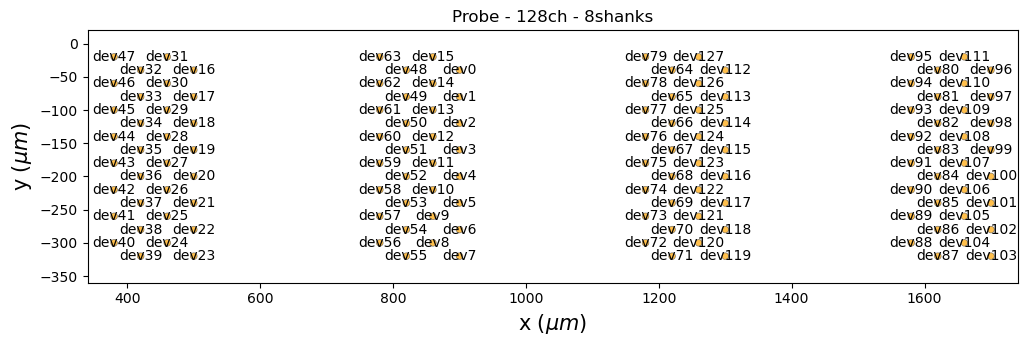

In [15]:
chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]
chanMapmat_correct = loadmat(chanMapPath)
x = chanMapmat_correct['xcoords'].flatten()
y = chanMapmat_correct['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat_correct['kcoords'].flatten()
device_ch_inds = chanMapmat_correct['chanMap'].flatten() - 1
# bad_ch_ids = np.where(chanMapmat_correct['connected'][:,0]==0)[0]
bad_ch_ids = []

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(12,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

# Create recording object

In [16]:
# Sampling frequency and channel count
fs = get_sampling_rate(xmlPath)
num_channels = len(device_ch_inds)
recording_list = []

# Read and load each binary recording file
for i in range(len(dataPath)):
    recording_ = se.read_binary(
        dataPath[i],
        sampling_frequency=fs,
        dtype='int16',
        num_channels=num_channels,
        gain_to_uV=0.195,
        offset_to_uV=0
    )
    print(dataPath[i])
    recording_list.append(recording_)

# Concatenate all recordings into single recording object
recording = si.concatenate_recordings(recording_list)


/local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01/sake_day01.dat


# Prepare preprocessed data

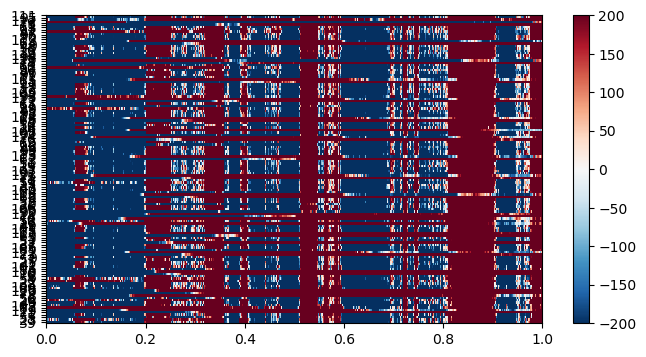

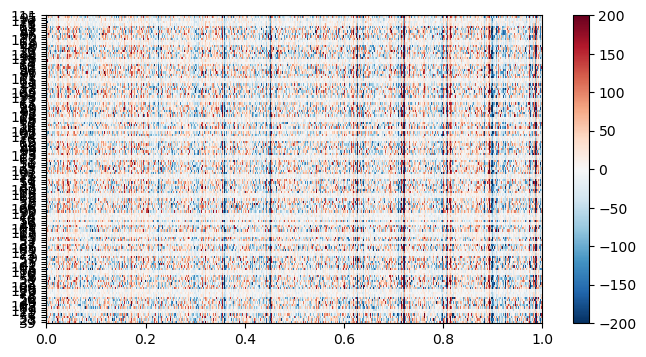

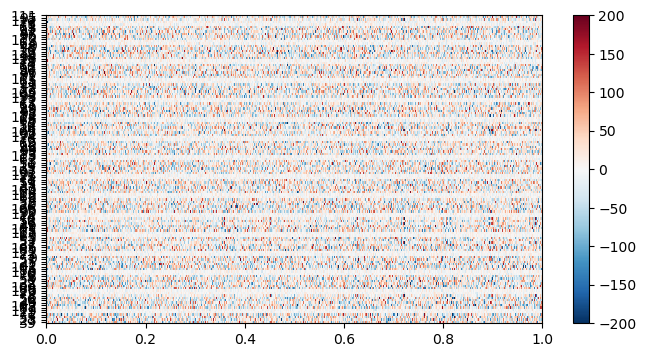

In [17]:
# Set probe and remove bad channels
# Use set_probegroup for ProbeGroup objects
# recording_raw = recording.set_probegroup(probe, group_mode='by_shank')
recording_raw = recording.set_probegroup(probegroup=probe, group_mode='by_probe')
recording_raw = recording_raw.remove_channels(remove_channel_ids=bad_ch_ids)

# Plot parameters
tmin = 0
twind = 1
segment_index = 0

# Plot raw traces
sw.plot_traces(
    recording_raw,
    channel_ids=recording_raw.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)

# Apply bandpass filter (500-8000 Hz)
recording_f = spre.bandpass_filter(recording_raw, freq_min=500, freq_max=8000)
sw.plot_traces(
    recording_f,
    channel_ids=recording_f.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)

# Apply common median reference (local)
recording_cmr = spre.common_reference(
    recording_f,
    reference='local',
    local_radius=[50, 200],
    operator='median'
)
sw.plot_traces(
    recording_cmr,
    channel_ids=recording_cmr.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)


# Load sorting result
### When you load Kilosort 1 result from  Neurocode, delete cluster_group.tsv

In [18]:
sorting_folder = glob.glob(basepath + '/Kilosort_*')[0]
# sorting_folder = glob.glob(str(Path(outputDir) / 'Kilosort*/sorter_output'))[0]
sorting = se.read_phy(sorting_folder)
sorting

PhySortingExtractor: 179 units - 1 segments - 20.0kHz

# Post-hoc automatic curation

In [19]:
# Remove duplicated spikes within 0.5ms of same cluster
sorting_removed_duplicates = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.5)

# Create sorting analyzer for quality assessment
sa_tmp = si.create_sorting_analyzer(
    sorting_removed_duplicates,
    recording_cmr,
    format="memory",
    sparse=False
)

# Remove redundant units (putative duplicates)
sorting_clean, redundancy_info = scur.remove_redundant_units(
    sa_tmp, 
    align=False, 
    duplicate_threshold=0.5,
    remove_strategy="max_spikes",
    extra_outputs=True,
)
print(f"Removed {len(redundancy_info)} redundant cluster combinations.")

Removed 63 redundant cluster combinations.


## Compute unit features 

In [20]:
# Create or load sorting analyzer with computed features
analyzer_folder = Path(Path(sorting_folder) / 'analyzer_cache')

if analyzer_folder.exists():
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)
    print("Loaded existing analyzer from disk.")
else:
    # Create new analyzer
    analyzer = si.create_sorting_analyzer(
        sorting=sorting_clean,
        recording=recording_cmr,
        format="binary_folder",   
        folder=analyzer_folder,
        overwrite=True,
        **job_kwargs,
    )

    # Compute all required features
    analyzer.compute(
        {
            "random_spikes": {"method": "all"}, 
            
            "waveforms": {},
            "templates": {},          
            "noise_levels": {},
            "spike_amplitudes": {},
            "principal_components": {"n_components": 5, "mode": "by_channel_local"}, 
            "template_metrics": {},       
            "template_similarity": {},    
            "correlograms": {},
            "spike_locations": {},
            "unit_locations": {},
        },
        **job_kwargs,  
    )
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)

estimate_sparsity (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s]

compute_waveforms (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/151 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/151 [00:00<?, ?it/s]

/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/postprocessing/principal_component.py:565: UserWarning: Projection attempted on unfitted PCA models. This could be due to a small number of waveforms for a particular unit.
  warnings.warn(
/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/postprocessing/template_metrics.py:644: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = scipy.stats.linregress(times[peak_idx:max_idx], template_single[peak_idx:max_idx])


Compute : spike_amplitudes + spike_locations (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s…

## Merge units

In [21]:
# Define merge criteria for clustering
steps_params = {
    "num_spikes": {           
        "min_spikes": 100,    
    },
    "correlogram": {
        "corr_diff_thresh": 0.25,
    },
    "template_similarity": {
        "template_diff_thresh": 0.25
    }
}

# Compute merge candidates based on similarity and correlograms
print("Computing merge candidates...")
merge_groups = scur.compute_merge_unit_groups(
    analyzer,                   
    preset="similarity_correlograms", 
    resolve_graph=True,               
    steps_params=steps_params    
)
print(f"Found {len(merge_groups)} groups to merge.")

Computing merge candidates...
Found 0 groups to merge.


In [22]:
for i in range(len(merge_groups)):
    sw.plot_crosscorrelograms(
        sorting_analyzer_or_sorting=analyzer,
        unit_ids=merge_groups[i],            
        bin_ms=1,
        window_ms=25.0,
        figsize=(4, 3)
    )

In [23]:
# Check which unit groups can be safely merged
mergeable = analyzer.are_units_mergeable(
    merge_unit_groups=merge_groups,
    merging_mode="soft",
    sparsity_overlap=0.5
)

# Filter to only safely mergeable groups
merge_groups = [g for g, ok in mergeable.items() if ok]
nonmerge_groups = [g for g, ok in mergeable.items() if not ok]

# Create analyzer with merged units
analyzer_merged_folder = Path(sorting_folder) / "analyzer_cache_merged"
if analyzer_merged_folder.exists():
    try:
        shutil.rmtree(analyzer_merged_folder)
    except:
        pass

if len(merge_groups)!=0:
    analyzer_merged = analyzer.merge_units(
        merge_unit_groups=merge_groups,
        merging_mode='soft', 
        censor_ms=0.5, 
        sparsity_overlap=0.5,
        return_new_unit_ids=False, 
        format="binary_folder", 
        folder=analyzer_merged_folder,
        overwrite=True,       
        **job_kwargs     
)
    
else:
    analyzer_merged = analyzer
    print("No units to merge.")

No units to merge.


## Split deviated waveforms

In [24]:
from utils.unit_split import autosplit_outliers_pca
sorting_split = autosplit_outliers_pca(
    analyzer_merged,
    # ---- distance (Mahalanobis) gate ----
    contamination=0.05,
    threshold_mode="adaptive_chi2",
    min_clean_frac=0.8,
    relax_factor=0.5,
    # ---- waveform similarity (Rescue) ----
    use_waveform_gate=True,        
    wf_threshold=0.3,          
    wf_template_max=1000,                        
    wf_n_chans=10,
    min_spikes=10,               
    wf_center="demean", 
    squeeze_all_outlier_to_new=True,
    return_details=False,
    verbose=True,
)

unit 0 (orig) -> unit 0 (clean, 45475 spikes) | split to unit 1 (outliers, 601 spikes)
unit 1 (orig) -> unit 2 (clean, 2670 spikes) | split to unit 3 (outliers, 13 spikes)
unit 2 (orig) -> unit 4 (new): kept (735 spikes) | discarded 5 outliers (below min_spikes=10)
unit 3 (orig) -> unit 5 (clean, 4613 spikes) | split to unit 6 (outliers, 1468 spikes)
unit 4 (orig) -> unit 7 (clean, 3554 spikes) | split to unit 8 (outliers, 1872 spikes)
unit 5 (orig) -> unit 9 (clean, 3817 spikes) | split to unit 10 (outliers, 206 spikes)
unit 6 (orig) -> unit 11 (clean, 1183 spikes) | split to unit 12 (outliers, 293 spikes)
unit 7 (orig) -> unit 13 (clean, 356 spikes) | split to unit 14 (outliers, 10 spikes)
unit 8 (orig) -> unit 15 (clean, 1453 spikes) | split to unit 16 (outliers, 54 spikes)
unit 9 (orig) -> unit 17 (clean, 28387 spikes) | split to unit 18 (outliers, 1023 spikes)
unit 10 (orig) -> unit 19 (clean, 1710 spikes) | split to unit 20 (outliers, 266 spikes)
unit 11 (orig) -> unit 21 (clean,

## Compute unit features again

In [25]:

analyzer_split = si.create_sorting_analyzer(
    sorting=sorting_split,
    recording=recording_cmr,
    format="memory",   
    folder=analyzer_folder,
    overwrite=True,
    **job_kwargs,
)

# Compute all required features
analyzer_split.compute(
    {
        "random_spikes": {"method": "all"}, 
        "waveforms": {},
        "templates": {},          
        "noise_levels": {},
        "spike_amplitudes": {},
        "principal_components": {"n_components": 5, "mode": "by_channel_local"},
        "template_metrics": {},       
        "template_similarity": {},    
        "correlograms": {},
        "spike_locations": {},
        "unit_locations": {},
    },
    **job_kwargs,  
)


estimate_sparsity (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s]

compute_waveforms (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/189 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/189 [00:00<?, ?it/s]

/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/postprocessing/template_metrics.py:644: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = scipy.stats.linregress(times[peak_idx:max_idx], template_single[peak_idx:max_idx])


Compute : spike_amplitudes + spike_locations (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s…

## Compute unit metrics

In [26]:
# Get default quality metric parameters
qm_params = sqm.get_default_qm_params()

# Compute quality metrics for all units
metrics_df = sqm.compute_quality_metrics(
    analyzer_split,
    metric_names=['isi_violation', 'presence_ratio', 'snr', 'amplitude_median'],
    metric_params=qm_params,
    skip_pc_metrics=True,  # PCs are computed above
    n_jobs=n_jobs,
    progress_bar=True
)

## Export to phy and noise classification

In [27]:
# Export sorting results to Phy format for manual curation
phydir2 = Path(sorting_folder).parent / f"{Path(sorting_folder).name}_postprocessed"
export_to_phy(
    sorting_analyzer=analyzer_split,
    output_folder=phydir2,
    compute_pc_features=True,  
    compute_amplitudes=True,    
    copy_binary=False,           
    remove_if_exists=True,
    template_mode='average',
    add_quality_metrics=True,
    add_template_metrics=True,
    dtype=None,
    use_relative_path=True,
    verbose=True,
    **job_kwargs
)

# Fix params.py for Phy
params_file = Path(phydir2) / "params.py"

with open(params_file, 'r') as f:
    content = f.read()

# 1. Set dat_path to concatenated binary file
# Fix: convert Path object to string for concatenation or use / operator with string conversion
dat_files = glob.glob(str(outputDir / "*.dat"))
if dat_files:
    dat_relative_path = dat_files[0]
    content = content.replace("dat_path = None", f"dat_path = [r'{dat_relative_path}']")
else:
    print(f"Warning: No .dat files found in {outputDir}")

# 2. Set hp_filtered flag (data is already filtered)
new_hp_line = "hp_filtered = False"
if re.search(r"hp_filtered\s*=", content):
    content = re.sub(r"hp_filtered\s*=.*", new_hp_line, content)
else:
    content += f"\n{new_hp_line}"

# Write updated params back
with open(params_file, 'w') as f:
    f.write(content)

print(f"Fixed dat_path in {params_file}")
print(f"Set dat_path to: {dat_relative_path if dat_files else 'None'}")

extract PCs (workers: 506 processes):   0%|          | 0/6746 [00:00<?, ?it/s]

Run:
phy template-gui  /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01/Kilosort_2026-01-01_221509_postprocessed/params.py
Fixed dat_path in /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01/Kilosort_2026-01-01_221509_postprocessed/params.py
Set dat_path to: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/sake_day01/sake_day01.dat


In [28]:
from utils.unit_classify import mark_noise_clusters_from_metrics
# Define quality thresholds for automatic noise cluster labeling
th = dict(
    isi_violations_ratio_gt=3,         # Mark as noise if ISI ratio > 3
    isi_violations_count_gt=50,        # AND violation count > 50
    presence_ratio_lt=0.1,             # OR presence ratio < 0.1
    snr_lt=0.3,                        # OR SNR < 0.3
    amplitude_median_lt=25.0,          # OR absolute amplitude < 25 µV
)

# Apply automatic noise labeling
updated = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

# of noise clusters: 123
